In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms
from torchvision.io import read_image
from model import RedCNN
from customDataset import CatdogDataset
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil

from PIL import Image
from IPython.display import display
import warnings
from sklearn.preprocessing import normalize
warnings.filterwarnings('ignore')

In [2]:
gtpath="../dogData/gt/"
gtfiles=[]
for folder, subfolder, filenames in os.walk(gtpath):
    for files in filenames:
        gtfiles.append(files)
        

noisepath="../dogData/noise/"
noisefiles=[]
for folder, subfolder, filenames in os.walk(noisepath):
    for files in filenames:
        noisefiles.append(files)
        
#check whether both noise and gt have same files
print(gtfiles==noisefiles)

True


In [3]:
dogdataset= CatdogDataset(data_path=noisepath,target_path=gtpath,filenames=gtfiles)
train_size=int(0.7*len(dogdataset))
test_size=len(dogdataset)-train_size
trainset,testset=random_split(dogdataset,[train_size,test_size],generator=torch.manual_seed(42))


In [4]:
# model_dog=RedCNN()
# model_dog.load_state_dict(torch.load("trained_on_cat_130batch.pth.tar"))
# print(model_dog)
# criterion=nn.MSELoss()
# optimizer = torch.optim.Adam(model_dog.parameters(), lr=0.0001)

In [5]:
# ##Training
# optimizer.zero_grad()
# ewc_lambda=0.1

# param_dict=torch.load("parameter_dict.pth.tar")
# fisher_dict=torch.load("fisher_dict.pth.tar")

# train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
# test_loader = DataLoader(testset, batch_size=32, shuffle=True)


# losses_batch=[]
# trained_psnr=[]
# for i, data in enumerate(train_loader):

#     inputt, target=data

#     target_pred=model_dog(inputt)

#     img=inputt.detach().numpy()
#     recon_image=target_pred.detach().numpy()
#     for j in range(len(target)):
#         trained_psnr.append(cv2.PSNR(img[j],recon_image[j]))

#     loss=criterion(target_pred,target)

#     for name, param in model_dog.named_parameters():
#         fisher=fisher_dict[name]
#         theta_star=param_dict[name]
#         loss+=(fisher*(param-theta_star).pow(2)).sum()*ewc_lambda




#     losses_batch.append(loss.item())
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     if (i%10==0):
#         print(f"Epoch: 1 Loss:{loss.item()} Batch:{i}")




In [6]:
# fisher_dict={}
# param_dict={}
            
# for name, param in model.named_parameters():
#     param_dict[name] = param.data.clone()
#     fisher_dict[name] = param.grad.data.clone().pow(2)

# param_dictfile="parameter_dict.pth.tar"
# fisher_dictfile="fisher_dict.pth.tar"

# torch.save(fisher_dict,fisher_dictfile)
# torch.save(param_dict,param_dictfile)
modelfile="trained_on_dogwithewc.pth.tar"

# torch.save(model_dog.state_dict(),modelfile)

In [7]:
model=RedCNN()

model.load_state_dict(torch.load(modelfile))

<All keys matched successfully>

In [8]:
gt_psnr=[]
train_psnr=[]
for i in range(len(testset)):
    noise,gt=testset[i]
    gt_psnr.append(cv2.PSNR(noise.numpy(),gt.numpy()))
    train_psnr.append(cv2.PSNR(model(noise.view(-1,3,224,224)).detach().numpy().reshape(3,224,224),gt.numpy()))
    
print(f"Ground Truth PSNR(trainset): {sum(gt_psnr)/len(gt_psnr)}")
print(f"PSNR after applying model: {sum(train_psnr)/len(train_psnr)}")

Ground Truth PSNR(trainset): 18.688907881062395
PSNR after applying model: 23.90708269583512


In [9]:
torch.save(gt_psnr,"gt_psnr_dogtest.pth.tar")
torch.save(train_psnr,"psnr_of_the_dogtest_set_after_applyingewcmodel.pth.tar")

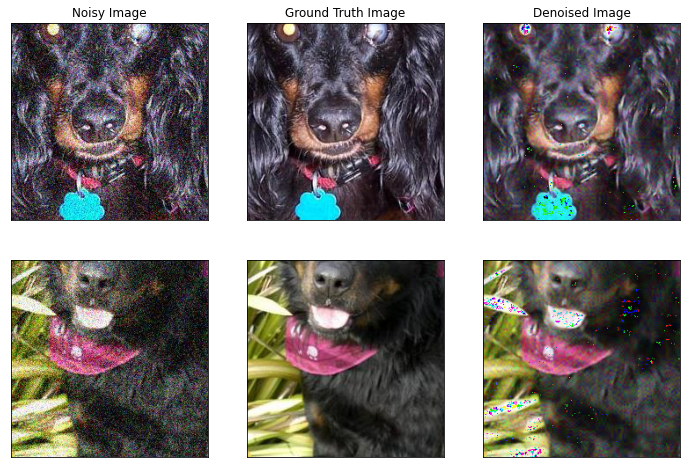

In [10]:
##Visualize the result with the image

input_image,target_image=testset[0]

input_image=input_image.view(-1,3,224,224)
target_image=target_image.view(-1,3,224,224)

input_image2,target_image2=testset[690]
input_image2=input_image2.view(-1,3,224,224)
target_image2=target_image2.view(-1,3,224,224)
with torch.no_grad():
    netoutput_image=model(input_image)
    netoutput_image2=model(input_image2)

    

fig, ax = plt.subplots(2, 3,figsize=(12, 8))


ax[0][0].imshow(np.transpose(input_image.view(3,224,224).to(torch.uint8),(1,2,0)))
ax[0][1].imshow(np.transpose(target_image.view(3,224,224).to(torch.uint8),(1,2,0)))
ax[0][2].imshow(np.transpose(netoutput_image.view(3,224,224).to(torch.uint8),(1,2,0)))

ax[1][0].imshow(np.transpose(input_image2.view(3,224,224).to(torch.uint8),(1,2,0)))
ax[1][1].imshow(np.transpose(target_image2.view(3,224,224).to(torch.uint8),(1,2,0)))
ax[1][2].imshow(np.transpose(netoutput_image2.view(3,224,224).to(torch.uint8),(1,2,0)))

# Add titles to each subplot
ax[0][0].set_title('Noisy Image')
ax[0][1].set_title('Ground Truth Image')
ax[0][2].set_title('Denoised Image')

# # Remove the x and y ticks
for a in ax.flat:
    a.set_xticks([])
    a.set_yticks([])

# Show the plot
plt.show()

